In [1]:
# 
from langgraph.graph import StateGraph, END
from typing import TypedDict, Optional
from IPython.display import Image, display

In [ ]:
# --------- ① State 정의 ---------
class GraphState(TypedDict, total=False):
    form: Optional[str]
    scenario: Optional[str]
    question: Optional[str]
    relevance_score: Optional[float]
    answer: Optional[str]
    eval_score: Optional[float]

In [3]:
# --------- ② 더미 노드 정의 ---------
# 실제 agent 호출은 생략하고, 단순 print 형태로 대체

class DummyNode:
    def __init__(self, name):
        self.name = name
    def __call__(self, state):
        print(f"✅ Executing node: {self.name}")
        return state

In [4]:
# --------- ③ 그래프 빌더 (최종 완성) ---------
def build_graph():
    g = StateGraph(GraphState)

    # ── 노드 등록 ───────────────────────────────────────
    g.add_node("classify_form", DummyNode("classify_form"))
    g.add_node("classify_specific", DummyNode("classify_specific"))
    g.add_node("evaluate_relevance", DummyNode("evaluate_relevance (RAG)"))
    g.add_node("question_remake", DummyNode("question_remake"))
    g.add_node("eval_chunk_agent", DummyNode("eval_chunk_agent"))
    g.add_node("ft_model", DummyNode("ft_model"))
    g.add_node("generate_answer", DummyNode("generate_answer"))
    g.add_node("eval_qa", DummyNode("eval_qa"))

    # ── entrypoint ─────────────────────────────────────
    g.set_entry_point("classify_form")
    g.add_edge("classify_form", "classify_specific")

    # ── classify_specific 분기 ─────────────────────────
    # - interview : ft_model로 직행
    # - university    : evaluate_relevance로
    # - end       : 바로 종료 (사용자 입력 종료)
    def route_from_specific(state: GraphState):
        scenario = state.get("scenario", "interview")
        if scenario not in {"interview", "university", "end"}:
            scenario = "interview"
        return scenario

    g.add_conditional_edges(
        "classify_specific",
        route_from_specific,
        {
            "interview": "ft_model",
            "university": "evaluate_relevance",
            "end": END,  # classify_specific → end
        },
    )

    # ── evaluate_relevance 분기 ────────────────────────
    # - good : eval_chunk_agent
    # - bad  : question_remake
    # - end  : 평가 중단 시 바로 종료
    def cond_relevance(state: GraphState):
        status = state.get("relevance_status", "good")
        if status not in {"good", "bad", "end"}:
            status = "good"
        return status

    g.add_conditional_edges(
        "evaluate_relevance",
        cond_relevance,
        {
            "good": "eval_chunk_agent",
            "bad": "question_remake",
            "end": END,  # 바로 종료 경로 추가
        },
    )
    g.add_edge("question_remake", "evaluate_relevance")  # 루프 복원
    g.add_edge("eval_chunk_agent", "ft_model")           # 정상 루트

    # ── eval_chunk_agent 예외 루트 (바로 종료 가능) ──
    g.add_conditional_edges(
        "eval_chunk_agent",
        lambda s: s.get("chunk_status", "continue"),
        {
            "continue": "ft_model",
            "end": END,  # 평가 중단 시 종료
        },
    )

    # ── 생성 및 평가 → 종료 ───────────────────────────
    g.add_edge("ft_model", "generate_answer")
    g.add_edge("generate_answer", "eval_qa")
    g.add_edge("eval_qa", END)

    return g


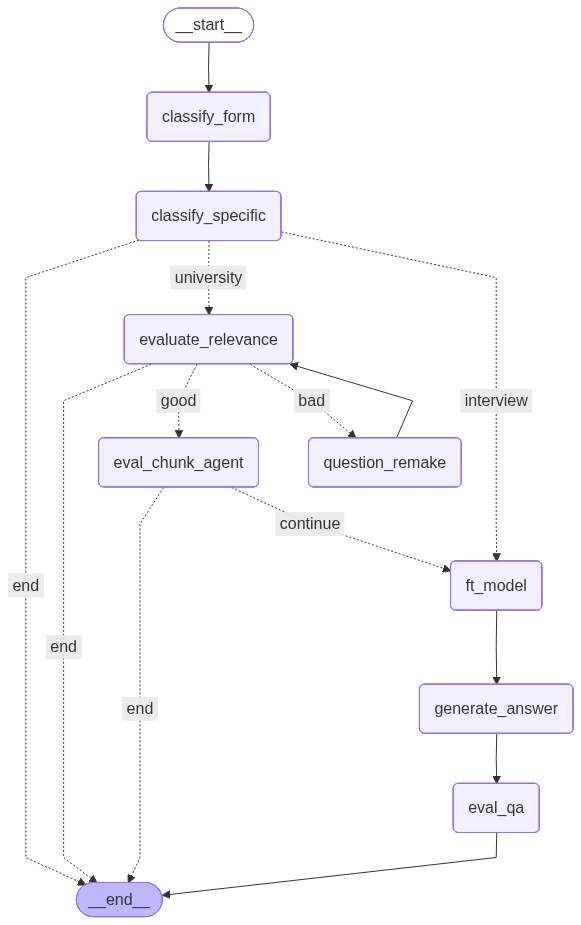

In [5]:
# --------- ④ 시각화 ---------
graph = build_graph()

# LangGraph는 build_graph() 후 compile()을 호출해야 내부 구조 완성.
app = graph.compile()

# draw_mermaid_png()는 compile된 객체(app)에서 호출해야함
display(Image(app.get_graph().draw_mermaid_png()))
